In [551]:
import pandas as pd
import numpy as np

In [552]:
df = pd.read_csv('data/SBAnational.csv', dtype='unicode')
pd.set_option('display.max_columns', None)
df.head(1)

,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,Term,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural,RevLineCr,LowDoc,ChgOffDate,DisbursementDate,DisbursementGross,BalanceGross,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv
0,1000014003,ABC HOBBYCRAFT,EVANSVILLE,IN,47711,FIFTH THIRD BANK,OH,451120,28-Feb-97,1997,84,4,2,0,0,1,0,N,Y,NaN,28-Feb-99,"$60,000.00",$0.00,P I F,$0.00,"$60,000.00","$48,000.00"


# Explication de variables

- `DisbursementGross` signifie que plus le montant du prêt est élevé, plus cela signifie que l'entreprise sera établie et en expansion => augmente la probabilité de rembourser le prêt.
- `State` suivant l'Etat dans lequel est contracté le prêt, cela impacte le taux de celui-ci 

<img src="data/state.jpg" />

- `NAICS` les 2 premiers chiffres de cette colonne représente un type d'industrie

|2 digit code|Description|Default rate (%)|
|:----|:----|:----|
|21|Mining, quarrying, and oil and gas extraction|8|
|11|Agriculture, forestry, fishing and hunting|9|
|55|Management of companies and enterprises|10|
|62|Health care and social assistance|10|
|22|Utilities|14|
|92|Public administration|15|
|54|Professional, scientific, and technical services|19|
|42|Wholesale trade|19|
|31–33|Manufacturing|19, 16, 14|
|81|Other services (except public administration)|20|
|71|Arts, entertainment, and recreation|21|
|72|Accommodation and food services|22|
|44–45|Retail trade|22, 23|
|23|Construction|23|
|56|Administrative/support & waste management/remediation Service|24|
|61|Educational services|24|
|51|Information|25|
|48–49|Transportation and warehousing|27, 23|
|52|Finance and insurance|28|
|53|Real estate and rental and leasing|29|

- `NewExist` le fait qu'une entreprise soit nouvelle ou établie. 1 si >= 2 ans, 2 sinon

# Copie pour perf

In [553]:
df_sba = df.copy()
df_sba.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 899164 entries, 0 to 899163
Data columns (total 27 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   LoanNr_ChkDgt      899164 non-null  object
 1   Name               899150 non-null  object
 2   City               899134 non-null  object
 3   State              899150 non-null  object
 4   Zip                899164 non-null  object
 5   Bank               897605 non-null  object
 6   BankState          897598 non-null  object
 7   NAICS              899164 non-null  object
 8   ApprovalDate       899164 non-null  object
 9   ApprovalFY         899164 non-null  object
 10  Term               899164 non-null  object
 11  NoEmp              899164 non-null  object
 12  NewExist           899028 non-null  object
 13  CreateJob          899164 non-null  object
 14  RetainedJob        899164 non-null  object
 15  FranchiseCode      899164 non-null  object
 16  UrbanRural         8

# nettoyage et formatage des data

In [554]:
def transform_curracy(df, columns):
    for col in columns:
        df[col] = df[col].replace(r'[\$ ,]', '', regex=True).astype(float)

def transform_date(df, columns, format='%d-%b-%y'):
    for col in columns:
        try:
            df[col] = pd.to_datetime(df[col], format=format, errors='raise')
        except ValueError:
            print('Erreur sur la date col:', col)
            pass

transform_curracy(df_sba, ['GrAppv', 'DisbursementGross', 'SBA_Appv', 'ChgOffPrinGr'])
transform_date(df_sba, ['ApprovalDate', 'DisbursementDate'])

df_sba.NAICS = df_sba.NAICS.astype(str).str[0:2].astype('category')
df_sba.ApprovalFY = df_sba.ApprovalFY.astype(str).str[0:4].astype(int)
df_sba.Term = df_sba.Term.astype(int)
df_sba.NoEmp = df_sba.NoEmp.astype(int)
df_sba.CreateJob = df_sba.CreateJob.astype(int)
df_sba.RetainedJob = df_sba.RetainedJob.astype(int)
df_sba.FranchiseCode = df_sba.FranchiseCode.astype('category')
df_sba.UrbanRural = df_sba.UrbanRural.astype('category')

df_sba.BankState = df_sba.BankState.astype('category')
df_sba.State = df_sba.State.astype('category')
df_sba.Zip = df_sba.Zip.astype('category')
df_sba.MIS_Status = df_sba.MIS_Status.astype('category')


## OHE de la target

In [555]:
from feature_engine.imputation import CategoricalImputer
from sklearn.preprocessing import LabelBinarizer

imputer = CategoricalImputer(imputation_method='frequent', variables=['MIS_Status'])
df_sba = imputer.fit_transform(df_sba)

df_sba.MIS_Status = LabelBinarizer().fit_transform(df_sba.loc[:,['MIS_Status']])
df_sba.MIS_Status = df_sba.MIS_Status.astype('category')

# display(df_sba.head(2))
# df_sba.info()


In [556]:
df_sba.LowDoc = df_sba.LowDoc.replace(r'[C1SRA0]', np.nan, regex=True)
df_sba.RevLineCr = df_sba.RevLineCr.replace(r'[0T`1C32R7A5\.,4\-Q]', np.nan, regex=True)
df_sba.NewExist = df_sba.NewExist.replace(r'[0]', np.nan, regex=True)

df_sba.FranchiseCode = df_sba.FranchiseCode.astype(int)
df_sba.FranchiseCode[df_sba.FranchiseCode > 0] = 1

df_sba.head(1)


/var/folders/zp/c97k147160ddnklbfc2rk3hr0000gn/T/ipykernel_3631/3211018845.py:6: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df_sba.FranchiseCode[df_sba.FranchiseCode > 0] = 1
/var/folders/zp/c97k147160ddnklbfc2rk3hr0000gn/T/ipykernel_3631

,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,Term,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural,RevLineCr,LowDoc,ChgOffDate,DisbursementDate,DisbursementGross,BalanceGross,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv
0,1000014003,ABC HOBBYCRAFT,EVANSVILLE,IN,47711,FIFTH THIRD BANK,OH,45,1997-02-28,1997,84,4,2,0,0,1,0,N,Y,NaN,1999-02-28,60000.0,$0.00,1,0.0,60000.0,48000.0


In [557]:
np.round(df_sba[['LowDoc', 'GrAppv']].loc[df_sba.LowDoc.isna()].describe(), 2)


,GrAppv
count,6007.00
mean,189969.72
std,257724.13
min,2500.00
25%,25000.00
50%,100000.00
75%,250000.00
max,2725000.00


## Imputer
### LowDoc RevLineCr NewExist

In [558]:
from feature_engine.imputation import RandomSampleImputer
imputer = RandomSampleImputer()
# LowDoc

df_sba.LowDoc = np.where(df_sba.LowDoc.isna(), 
                    np.where(df_sba.GrAppv < 150000, 1, 0), 
                    np.where(df_sba.GrAppv >= 150000, 0, 1))

#display(np.round(df_sba['LowDoc'].value_counts(), 2))

# RevLineCr
result = imputer.fit_transform(df_sba.loc[:,['RevLineCr']])
df_sba.RevLineCr = result['RevLineCr']
df_sba.RevLineCr = LabelBinarizer().fit_transform(df_sba.loc[:,['RevLineCr']])
df_sba.RevLineCr = df_sba.RevLineCr.astype('category')

# NewExist
result = imputer.fit_transform(df_sba.loc[:,['NewExist']])
df_sba.NewExist = result['NewExist']
imputer = CategoricalImputer(imputation_method='frequent', variables=['NewExist'])
df_sba = imputer.fit_transform(df_sba)
df_sba.NewExist = df_sba.NewExist.astype('category')

# on remplace les na de BankState avec la valeur de State (fortement corrélés)
df_sba.BankState = np.where(df_sba.BankState.isna(), df_sba.State, df_sba.BankState)
# Il en reste 1. City = Pennsville -> New Jersey -> BankState = NJ
df_sba.BankState = np.where(df_sba.BankState.isna(), 'NJ', df_sba.BankState)
# On supprime State
# df_sba.drop(columns=['State'], inplace=True)

df_sba.head(1)



,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,Term,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural,RevLineCr,LowDoc,ChgOffDate,DisbursementDate,DisbursementGross,BalanceGross,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv
0,1000014003,ABC HOBBYCRAFT,EVANSVILLE,IN,47711,FIFTH THIRD BANK,OH,45,1997-02-28,1997,84,4,2,0,0,1,0,0,1,NaN,1999-02-28,60000.0,$0.00,1,0.0,60000.0,48000.0


In [560]:
df_sba.to_pickle('data/SBAmodel.pickle')

: 

In [532]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df_sba.BankState = le.fit_transform(df_sba.loc[:,['BankState']])
df_sba.BankState = df_sba.BankState.astype('category')

df_sba.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 899164 entries, 0 to 899163
Data columns (total 27 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   LoanNr_ChkDgt      899164 non-null  object        
 1   Name               899150 non-null  object        
 2   City               899134 non-null  object        
 3   State              899150 non-null  category      
 4   Zip                899164 non-null  category      
 5   Bank               897605 non-null  object        
 6   BankState          899164 non-null  category      
 7   NAICS              899164 non-null  category      
 8   ApprovalDate       899164 non-null  datetime64[ns]
 9   ApprovalFY         899164 non-null  int64         
 10  Term               899164 non-null  int64         
 11  NoEmp              899164 non-null  int64         
 12  NewExist           899164 non-null  category      
 13  CreateJob          899164 non-null  int64   

/Users/maximekuil/Documents/Simplon/US-SBA/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [533]:
df_sba.to_pickle('data/SBAmodel.pickle')

0


<Axes: >

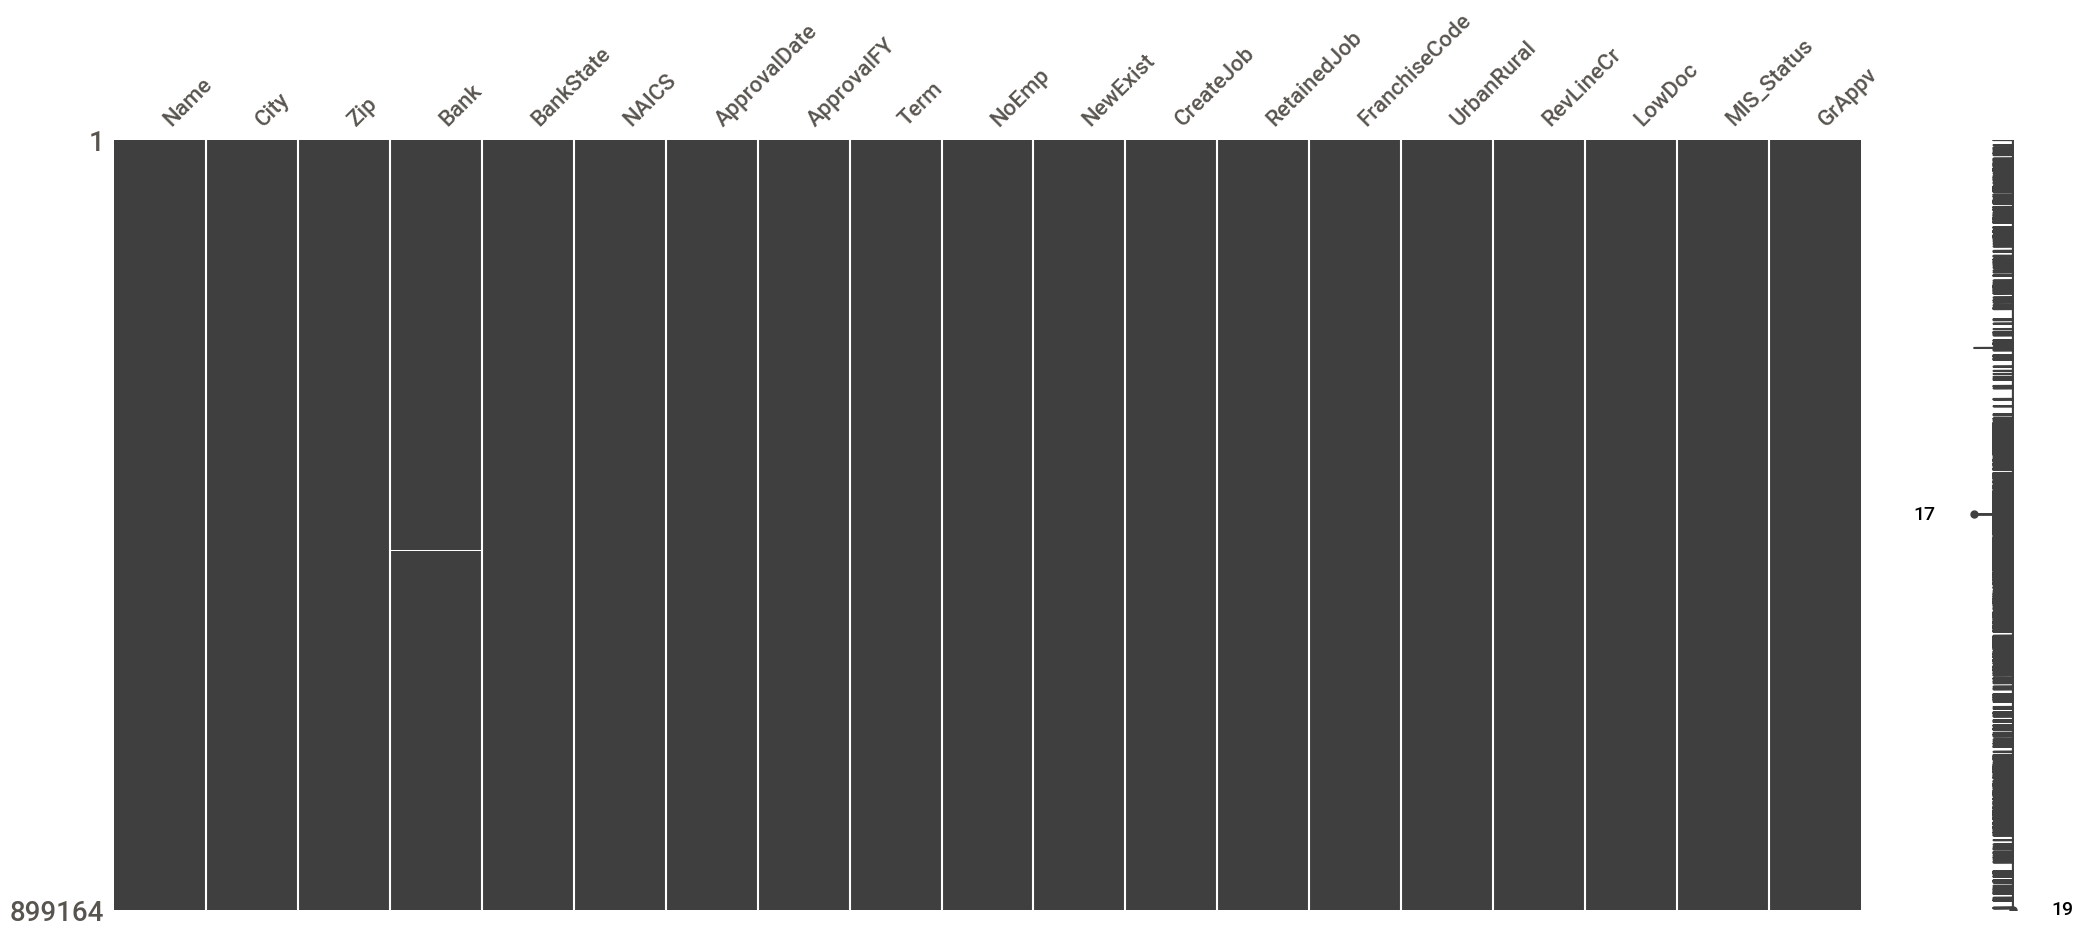

In [274]:
df_sba.head()

print(df_sba.MIS_Status.isna().sum())

import missingno as msno
msno.matrix(df_sba)

In [227]:
import sweetviz as sv
#print(df_sba.info())
feature_config = sv.FeatureConfig(force_num=["MIS_Status"])
df_sba.MIS_Status = df_sba.MIS_Status.astype(bool)
sweet_report = sv.analyze(df_sba, 'MIS_Status', pairwise_analysis='off')
sweet_report.show_html(filepath='sweetviz_eda/brut.html')

Feature: MIS_Status (TARGET)                 |▌         | [  5%]   01:10 -> (22:15 left)
Feature: GrAppv                              |██████████| [100%]   00:07 -> (00:00 left)


Report sweetviz_eda/brut.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [ ]:
# sweet_report = sv.compare_intra(df_sba, df_sba["Bank"] == "BANK OF AMERICA NATL ASSOC", ['BANK OF AMERICA NATL ASSOC', 'Autre'], "MIS_Status", feature_config)
# sweet_report.show_html()